<a href="https://colab.research.google.com/github/chandrika16-sys/1BM21AI142_Chandrika/blob/main/Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#IMPORTING LIBRARIES

In [2]:
from imblearn.over_sampling import RandomOverSampler, ADASYN
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, ParameterGrid, cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn import metrics


import warnings
warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Read the dataset

In [4]:
df = pd.read_csv("/content/drive/MyDrive/creditcard.csv")

#Initial Analysis

In [4]:
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

#Findings
1. There are no missing values
2. There are 30 independent variables
3. Standardization required as all the variables are on different scale
4. there is no correlation
5. normalization (data preprocessing)
6. the values pca components so that is why negative value
7. Unbalanced dataset
8. One different datatype

#Distribution of classes

In [5]:
classes=df['Class'].value_counts()
normal_share=classes[0]/df['Class'].count()*100
fraud_share=classes[1]/df['Class'].count()*100
classes

,count
Class,
0,284315
1,492


1. The data labels are highly imbalanced as there are more non-fradulent datapoints
2. Require SMOTE analysis (Synthetic Minority Oversampling Technique is specifically designed to tackle imbalanced datasets by generating synthetic samples for the minority class)

#Train-test split

In [5]:
# Train test split
y = df.pop("Class")
X = df

# Using stratify=y for splitting data into stratified fashion
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, stratify=y, random_state=42)

#Model Evaluation function

In [6]:
def model_evaluation(y_pred_proba_test):
#     Report for different thresholds
    thresholds = [i * 0.1 for i in range(0, 10)]
    print("----------------------------Results----------------------------")
#     best ROC score initialisation
    best_roc_score = 0

#     Iterating through every threshold from 0.1 to 0.9
    for threshold in thresholds:
        y_pred = np.where(y_pred_proba_test[:, 1] > threshold, 1, 0)
#   Calculating different metrics
        accuracy = str(round(metrics.accuracy_score(y_test, y_pred), 3))
        precision = str(round(metrics.precision_score(y_test, y_pred), 3))
        recall = str(round(metrics.recall_score(y_test, y_pred), 3))
        roc_auc = str(round(metrics.roc_auc_score(y_test, y_pred), 3))
#   Setting the best roc score, threshold, recall scores.
        if float(roc_auc) > best_roc_score:
            best_roc_score = float(roc_auc)
            best_threshold = threshold
            best_recall_score = recall
#   printing the results for every threshold
        print("----------for Test with threshold", round(threshold, 2), "----------")
        print("accuracy\tprecision\trecall\t\troc_auc")
        print("\t\t".join([accuracy, precision, recall, roc_auc]))
        print("\n")
#   Confusion Matrix
        print("\t\tCONFUSION MATRIX")
        confusion_matrix = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred),
                                        columns=['Predicted Negative', 'Predicted Positive'],
                                        index=['Actual Negative', 'Actual Positive'])
        print(confusion_matrix)
        print("\n")
    print("BEST ROC AUC SCORE is ", best_roc_score, "at the threshold", best_threshold)
    return best_roc_score, best_threshold, best_recall_score

#ROC-CURVE FUNCTION

In [7]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

#Distribution of classes with smote analysis

In [8]:
from collections import Counter
from imblearn.over_sampling import SMOTE
print("Class Distribution Before SMOTE:", Counter(y_train))

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Class Distribution After SMOTE:", Counter(y_train_smote))


Class Distribution Before SMOTE: Counter({0: 213236, 1: 369})
Class Distribution After SMOTE: Counter({0: 213236, 1: 213236})


#Result


In [9]:
results = pd.DataFrame(columns = ['model_name', 'threshold', 'recall', 'roc_auc_score'])

#RANDOM FOREST WITHOUT SMOTE ANALYSIS

Fitting 2 folds for each of 2 candidates, totalling 4 fits
BEST GRID SCORE 0.976742424001608
BEST GRID PARAMS
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
----------------------------Results----------------------------
----------for Test with threshold 0.0 ----------
accuracy	precision	recall		roc_auc
0.002		0.002		1.0		0.5


		CONFUSION MATRIX
                 Predicted Negative  Predicted Positive
Actual Negative                   0               71079
Actual Positive                   0                 123


----------for Test with threshold 0.1 ----------
accuracy	precision	recall		roc_auc
0.999		0.754		0.846		0.923


		CONFUSION MATRIX
                 Predicted Negative  Predicted Positive
Actual Negative               71045                  34
Actual Positive                  19                 104


----------for Test with threshold 0.2 ----------
accuracy	precision	recall		roc_auc
0.999		0.812		0.846		0.923


		CONFUSION MATRIX
         

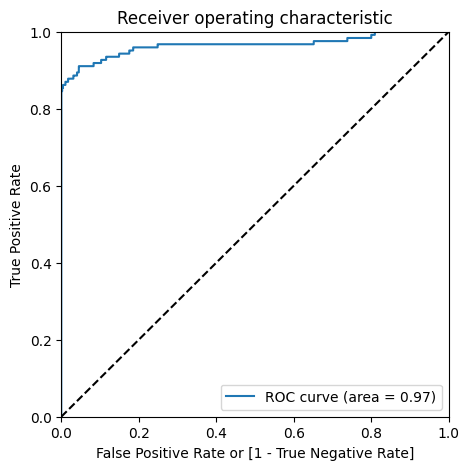

In [30]:
rf_model = RandomForestClassifier(random_state=42)
cv = KFold(2)
param_grid = {
    'n_estimators': [50],
    'max_depth': [None, 10],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
}


grid = GridSearchCV(rf_model,
                   param_grid=param_grid,
                   scoring='roc_auc',
                   cv=cv,
                   n_jobs=-1,
                   verbose=1000)
grid.fit(X_train, y_train)
print("BEST GRID SCORE", grid.best_score_)
print("BEST GRID PARAMS")
print(grid.best_params_)

best_rf_model = grid.best_estimator_
best_rf_model.fit(X_train, y_train)


y_pred_proba_test = best_rf_model.predict_proba(X_test)


best_roc_score, best_threshold, best_recall_score = model_evaluation(y_pred_proba_test)

data = pd.DataFrame([['Random Forest IMB', best_threshold, best_recall_score, best_roc_score]],
                    columns=results.columns)
results = pd.concat([results, data], ignore_index=False)

draw_roc(y_test, y_pred_proba_test[:, 1])


#Findings:
1. The model performs best at a threshold of 0.1 with a ROC AUC score of 0.923
2. For Lower Thresholds High recall (all frauds detected) but very low precision (many false positives).
3. For Higher Thresholds (e.g., 0.9): High precision (few false positives) but low recall (many frauds missed).
4. Accuracy remains high (~99.9%), but it’s misleading because the dataset is imbalanced

#RANDOM FOREST WITH SMOTE ANALYSIS

Fitting 2 folds for each of 2 candidates, totalling 4 fits

BEST GRID SCORE (SMOTE) 0.9942208712625338
BEST GRID PARAMS (SMOTE)
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
----------------------------Results----------------------------
----------for Test with threshold 0.0 ----------
accuracy	precision	recall		roc_auc
0.002		0.002		1.0		0.5


		CONFUSION MATRIX
                 Predicted Negative  Predicted Positive
Actual Negative                   2               71077
Actual Positive                   0                 123


----------for Test with threshold 0.1 ----------
accuracy	precision	recall		roc_auc
0.957		0.036		0.919		0.938


		CONFUSION MATRIX
                 Predicted Negative  Predicted Positive
Actual Negative               68030                3049
Actual Positive                  10                 113


----------for Test with threshold 0.2 ----------
accuracy	precision	recall		roc_auc
0.987		0.106		0.902		0.945


		CONFUSIO

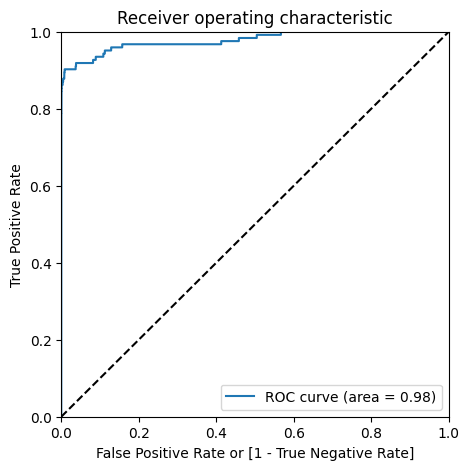

In [31]:

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

rf_model_smote = RandomForestClassifier(random_state=42)

cv = KFold(2)

param_grid = {
    'n_estimators': [50],
    'max_depth': [None, 10],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
}

grid_smote = GridSearchCV(rf_model_smote,
                         param_grid=param_grid,
                         scoring='roc_auc',
                         cv=cv,
                         n_jobs=-1,
                         verbose=1000)

grid_smote.fit(X_train_smote, y_train_smote)

print("\nBEST GRID SCORE (SMOTE)", grid_smote.best_score_)
print("BEST GRID PARAMS (SMOTE)")
print(grid_smote.best_params_)

best_rf_model_smote = grid_smote.best_estimator_
best_rf_model_smote.fit(X_train_smote, y_train_smote)

y_pred_proba_test_smote = best_rf_model_smote.predict_proba(X_test)

best_roc_score_smote, best_threshold_smote, best_recall_score_smote = model_evaluation(y_pred_proba_test_smote)

data_smote = pd.DataFrame([['Random Forest SMOTE', best_threshold_smote, best_recall_score_smote, best_roc_score_smote]],
                          columns=results.columns)
results = pd.concat([results, data_smote], ignore_index=False)

draw_roc(y_test, y_pred_proba_test_smote[:, 1])


#Findings
1. The best grid score (SMOTE) is 0.945, indicating an improvement in model performance due to balanced data.
2. At threshold 0.2, there is a good balance




#XG-BOOST WITHOUT SMOTE ANALYSIS

Fitting 2 folds for each of 4 candidates, totalling 8 fits
BEST GRID SCORE nan
BEST GRID PARAMS
{'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 50, 'classifier__subsample': 0.8}
----------------------------Results----------------------------
----------for Test with threshold 0.0 ----------
accuracy	precision	recall		roc_auc
0.002		0.002		1.0		0.5


		CONFUSION MATRIX
                 Predicted Negative  Predicted Positive
Actual Negative                   0               71079
Actual Positive                   0                 123


----------for Test with threshold 0.1 ----------
accuracy	precision	recall		roc_auc
0.999		0.699		0.829		0.914


		CONFUSION MATRIX
                 Predicted Negative  Predicted Positive
Actual Negative               71035                  44
Actual Positive                  21                 102


----------for Test with threshold 0.2 ----------
accur

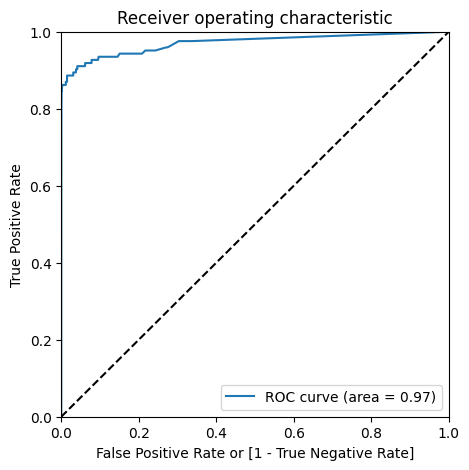

In [35]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline
import pandas as pd

xgb_model = XGBClassifier(use_label_encoder=False, random_state=42)
param_grid = {
    'classifier__n_estimators': [50],
    'classifier__max_depth': [3, 5],
    'classifier__learning_rate': [0.1, 0.2],
    'classifier__subsample': [0.8],
    'classifier__colsample_bytree': [0.8],
    'classifier__gamma': [0]
}

pipeline = Pipeline([
    ('classifier', xgb_model)
])


cv = KFold(2)


grid = GridSearchCV(pipeline,
                    param_grid=param_grid,
                    scoring='roc_auc',
                    cv=cv,
                    n_jobs=-1,
                    verbose=1000)


grid.fit(X_train, y_train)

print("BEST GRID SCORE", grid.best_score_)
print("BEST GRID PARAMS")
print(grid.best_params_)

best_xgb_model = grid.best_estimator_


y_pred_proba_test = best_xgb_model.named_steps['classifier'].predict_proba(X_test)
best_roc_score, best_threshold, best_recall_score = model_evaluation(y_pred_proba_test)

data = pd.DataFrame([['XGBoost IMB', best_threshold, best_recall_score, best_roc_score]], columns=results.columns)
results = pd.concat([results, data], ignore_index=False)

draw_roc(y_test, y_pred_proba_test[:, 1])


#Findings
1. highest ROC AUC score achieved is 0.914, which occurs at a threshold of 0.1
2. As the threshold increases, recall decreases
3. At threshold 0.9: Recall drops to 0.358, and ROC AUC is 0.679, which indicates poor performance in identifying positives




#XG-BOOST WITH SMOTE ANALYSIS



Fitting 2 folds for each of 4 candidates, totalling 8 fits

BEST GRID SCORE nan
BEST GRID PARAMS
{'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 50, 'classifier__subsample': 0.8}
----------------------------Results----------------------------
----------for Test with threshold 0.0 ----------
accuracy	precision	recall		roc_auc
0.002		0.002		1.0		0.5


		CONFUSION MATRIX
                 Predicted Negative  Predicted Positive
Actual Negative                   0               71079
Actual Positive                   0                 123


----------for Test with threshold 0.1 ----------
accuracy	precision	recall		roc_auc
0.919		0.019		0.919		0.919


		CONFUSION MATRIX
                 Predicted Negative  Predicted Positive
Actual Negative               65290                5789
Actual Positive                  10                 113


----------for Test with threshold 0.2 ----------
accu

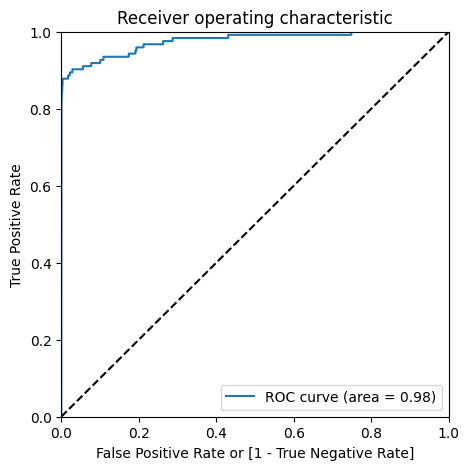

In [37]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, KFold
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
import pandas as pd

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

xgb_model = XGBClassifier(use_label_encoder=False, random_state=42)

param_grid = {
    'classifier__n_estimators': [50],
    'classifier__max_depth': [3, 5],
    'classifier__learning_rate': [0.1, 0.2],
    'classifier__subsample': [0.8],
    'classifier__colsample_bytree': [0.8],
    'classifier__gamma': [0]
}

pipeline = Pipeline([
    ('classifier', xgb_model)
])

cv = KFold(2)

grid = GridSearchCV(pipeline,
                    param_grid=param_grid,
                    scoring='roc_auc',
                    cv=cv,
                    n_jobs=-1,
                    verbose=1000)

grid.fit(X_train_smote, y_train_smote)

print("\nBEST GRID SCORE", grid.best_score_)
print("BEST GRID PARAMS")
print(grid.best_params_)

best_xgb_model = grid.best_estimator_

y_pred_proba_test = best_xgb_model.named_steps['classifier'].predict_proba(X_test)

best_roc_score, best_threshold, best_recall_score = model_evaluation(y_pred_proba_test)

data = pd.DataFrame([['XGBoost SMOTE', best_threshold, best_recall_score, best_roc_score]], columns=results.columns)
results = pd.concat([results, data], ignore_index=False)

draw_roc(y_test, y_pred_proba_test[:, 1])


#Findings
1. The best ROC AUC score (0.936) occurs at a threshold of 0.3 which provides a good balance
2. As the threshold increases, accuracy improves while recall decreases slightly. The precision also increases with the threshold, indicating fewer false positives but a higher risk of missing some actual positives
3. Here pipeline is done in order to streamline the workflow

#RESULT dataframe

In [40]:
results.sort_values("recall", ascending=False, inplace=True)
results = results.drop_duplicates(subset=['model_name'], keep='first')
results

,model_name,threshold,recall,roc_auc_score
0,Random Forest SMOTE,0.2,0.902,0.945
0,XGBoost IMB,0.3,0.894,0.936
0,XGBoost SMOTE,0.3,0.894,0.936
0,Random Forest IMB,0.1,0.846,0.923


#CONCLUSION
**For Large Banks:**
1. Random Forests:
*    Handles large datasets with high-dimensional data effectively. It is robust and flexible, making it ideal for tasks like fraud detection and credit scoring.

*   Provides high accuracy and prevents overfitting, suitable for diverse data types.

2. XGBoost:
Scalable and fast, especially for structured data in large datasets.

*   Scalable and fast, especially for structured data in large datasets.
*   Outperforms many algorithms in speed and accuracy, particularly on imbalanced data like fraud detection.

**For Small Banks:**
1. Logistic Regression:

*   Simple and interpretable, suitable for smaller datasets and binary tasks like fraud detection.
*   Efficient, easy to understand, and quick to train.

2. Decision Trees:

*   Transparent and easy to interpret, ideal for tasks like loan approval and credit scoring
*   Provides clear decision-making processes, helping meet regulatory requirements.


